In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    roc_curve, precision_recall_curve, auc, average_precision_score
)

from sklearn.decomposition import PCA
import joblib


In [26]:
path = r"C:\Users\X395\kuliah semester 5\PRAK_MACHINE_LEARNING\TUGAS 13\Penipuan Transaksi Digital.csv"

usecols = [
    "step","type","amount",
    "oldbalanceOrg","newbalanceOrig",
    "oldbalanceDest","newbalanceDest",
    "isFraud"
]

dtypes = {
    "step": "int32",
    "type": "category",
    "amount": "float32",
    "oldbalanceOrg": "float32",
    "newbalanceOrig": "float32",
    "oldbalanceDest": "float32",
    "newbalanceDest": "float32",
    "isFraud": "int8"
}

df = pd.read_csv(path, usecols=usecols, dtype=dtypes, low_memory=True, memory_map=True)

print("Shape:", df.shape)
df.head()


Shape: (6362620, 8)


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.639648,170136.0,160296.359375,0.0,0.0,0
1,1,PAYMENT,1864.280029,21249.0,19384.720703,0.0,0.0,0
2,1,TRANSFER,181.000000,181.0,0.000000,0.0,0.0,1
3,1,CASH_OUT,181.000000,181.0,0.000000,21182.0,0.0,1
4,1,PAYMENT,11668.139648,41554.0,29885.859375,0.0,0.0,0


In [27]:
print(df.info())

print("\nMissing values:")
print(df.isna().sum())

print("\nUnique values type:")
print(df["type"].value_counts().head(20))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            int32   
 1   type            category
 2   amount          float32 
 3   oldbalanceOrg   float32 
 4   newbalanceOrig  float32 
 5   oldbalanceDest  float32 
 6   newbalanceDest  float32 
 7   isFraud         int8    
dtypes: category(1), float32(5), int32(1), int8(1)
memory usage: 157.8 MB
None

Missing values:
step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

Unique values type:
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


Jumlah kelas:
 isFraud
0    6354407
1       8213
Name: count, dtype: int64

Persentase kelas:
 isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64


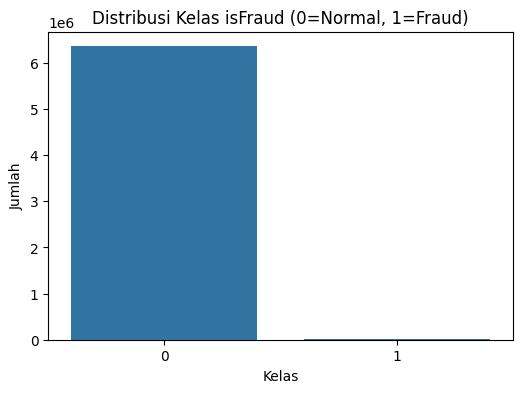

In [28]:
counts = df["isFraud"].value_counts()
pct = df["isFraud"].value_counts(normalize=True) * 100

print("Jumlah kelas:\n", counts)
print("\nPersentase kelas:\n", pct)

plt.figure(figsize=(6,4))
sns.barplot(x=counts.index.astype(str), y=counts.values)
plt.title("Distribusi Kelas isFraud (0=Normal, 1=Fraud)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.show()


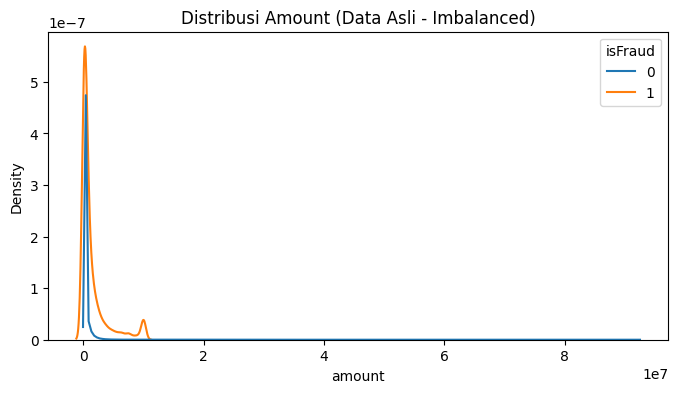

In [29]:
plt.figure(figsize=(8,4))
sns.kdeplot(data=df, x="amount", hue="isFraud", common_norm=False)
plt.title("Distribusi Amount (Data Asli - Imbalanced)")
plt.show()


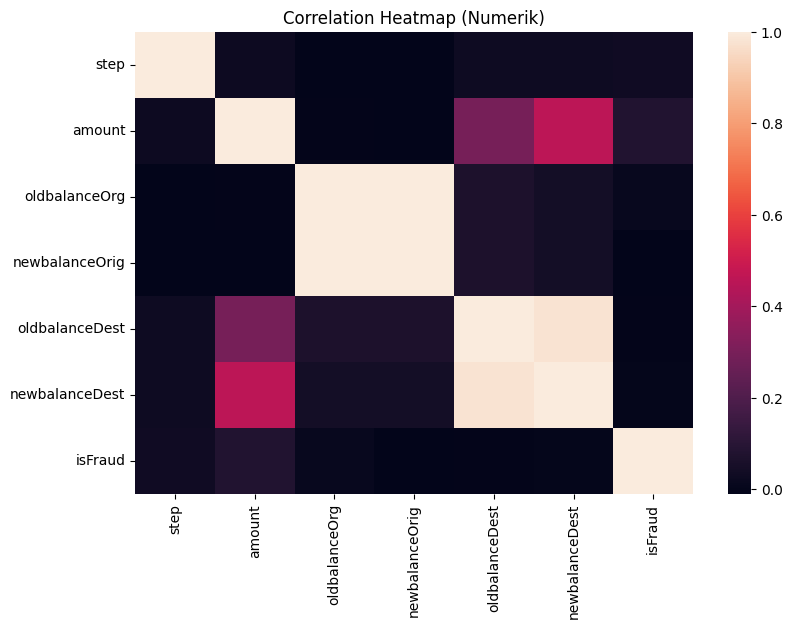

In [30]:
num_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(9,6))
sns.heatmap(num_df.corr(), annot=False)
plt.title("Correlation Heatmap (Numerik)")
plt.show()


Balanced shape: (16426, 8)
isFraud
0    8213
1    8213
Name: count, dtype: int64


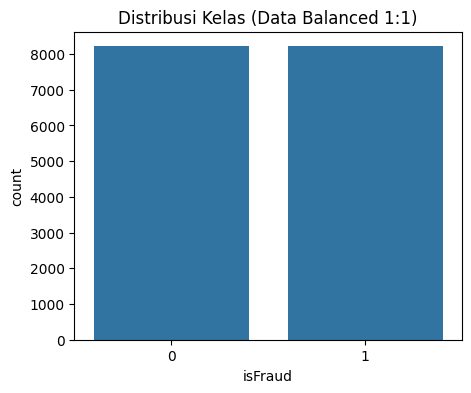

In [31]:
fraud = df[df["isFraud"] == 1]
normal = df[df["isFraud"] == 0]

n_fraud = len(fraud)
normal_down = normal.sample(n=n_fraud, random_state=42)

df_bal = pd.concat([fraud, normal_down]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced shape:", df_bal.shape)
print(df_bal["isFraud"].value_counts())

plt.figure(figsize=(5,4))
sns.countplot(data=df_bal, x="isFraud")
plt.title("Distribusi Kelas (Data Balanced 1:1)")
plt.show()


In [32]:
X = df_bal.drop(columns=["isFraud"])
y = df_bal["isFraud"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cat_cols = ["type"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (13140, 7) Test: (3286, 7)


In [33]:
svm_linear = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LinearSVC(max_iter=10000))
])

svm_linear.fit(X_train, y_train)
y_pred_lin = svm_linear.predict(X_test)

print("=== LinearSVC (Balanced) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lin))
print(classification_report(y_test, y_pred_lin, digits=4))


=== LinearSVC (Balanced) ===
Accuracy: 0.9455264759586123
              precision    recall  f1-score   support

           0     0.9415    0.9501    0.9458      1643
           1     0.9496    0.9410    0.9453      1643

    accuracy                         0.9455      3286
   macro avg     0.9456    0.9455    0.9455      3286
weighted avg     0.9456    0.9455    0.9455      3286



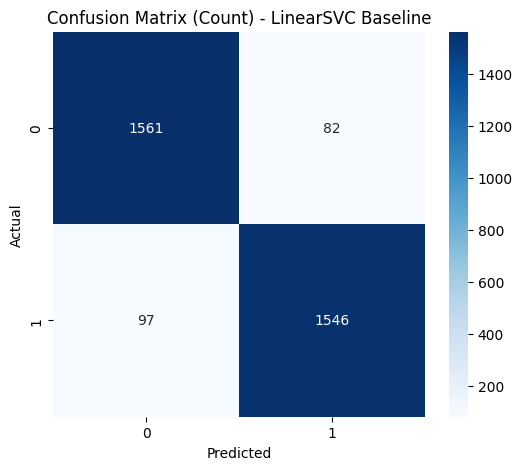

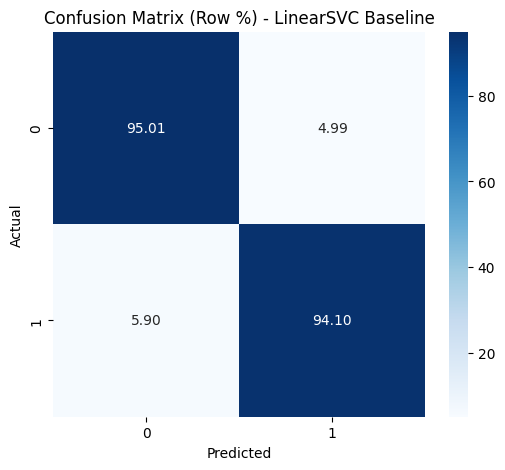

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Catatan: Cell ini akan menggunakan y_pred_lin dari cell 8
# Setelah cell 11 dijalankan, bisa ganti ke y_pred_best untuk melihat hasil model tuned
cm = confusion_matrix(y_test, y_pred_lin)
cm_pct = cm / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Count) - LinearSVC Baseline")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(cm_pct, annot=True, fmt=".2f", cmap="Blues")
plt.title("Confusion Matrix (Row %) - LinearSVC Baseline")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


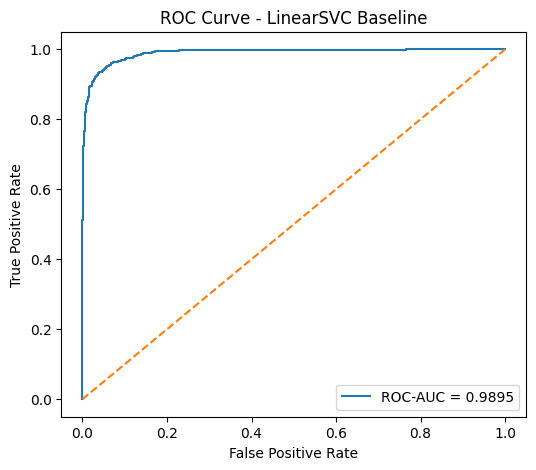

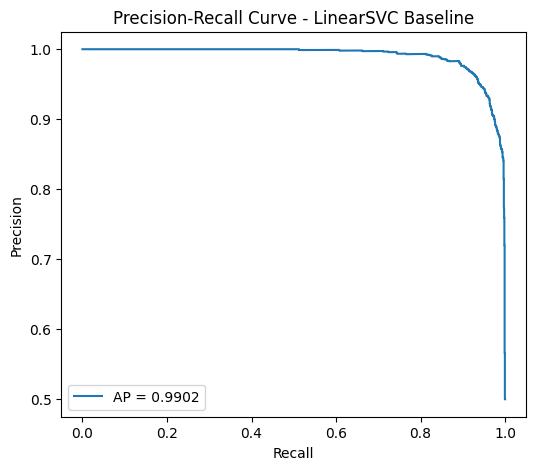

In [35]:
# Catatan: Cell ini menggunakan svm_linear dari cell 8
# Setelah cell 11 dijalankan, bisa ganti ke best_linear untuk melihat hasil model tuned
scores = svm_linear.decision_function(X_test)

# ROC
fpr, tpr, _ = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC Curve - LinearSVC Baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# PR
precision, recall, _ = precision_recall_curve(y_test, scores)
ap = average_precision_score(y_test, scores)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.title("Precision-Recall Curve - LinearSVC Baseline")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


In [36]:
param_grid = {"clf__C": [0.1, 1, 10]}

grid = GridSearchCV(
    svm_linear,
    param_grid=param_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

best_linear = grid.best_estimator_
y_pred_best = best_linear.predict(X_test)

print("\n=== LinearSVC Tuned ===")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, digits=4))


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Params: {'clf__C': 10}
Best CV F1: 0.946548156792689

=== LinearSVC Tuned ===
Accuracy: 0.9506999391357274
              precision    recall  f1-score   support

           0     0.9502    0.9513    0.9507      1643
           1     0.9512    0.9501    0.9507      1643

    accuracy                         0.9507      3286
   macro avg     0.9507    0.9507    0.9507      3286
weighted avg     0.9507    0.9507    0.9507      3286



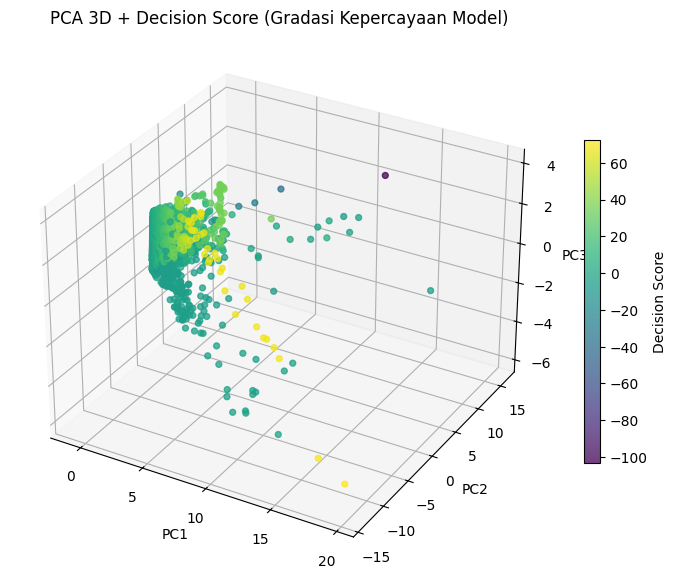

In [37]:
# CATATAN: Cell ini HARUS dijalankan SETELAH cell 11 (setelah best_linear didefinisikan)
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # noqa
import numpy as np
import matplotlib.pyplot as plt

# sampling biar enteng
N = min(8000, len(X_test))
idx = np.random.RandomState(42).choice(len(X_test), size=N, replace=False)
X_s = X_test.iloc[idx]
y_s = y_test.iloc[idx]

X_s_trans = preprocess.fit_transform(X_s)
X_s_dense = X_s_trans.toarray() if hasattr(X_s_trans, "toarray") else X_s_trans

pca3 = PCA(n_components=3, random_state=42)
X3 = pca3.fit_transform(X_s_dense)

score_s = best_linear.decision_function(X_s)  # buat warna gradasi

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection="3d")

p = ax.scatter(X3[:,0], X3[:,1], X3[:,2], c=score_s, s=18, alpha=0.75)
fig.colorbar(p, ax=ax, shrink=0.6, label="Decision Score")

ax.set_title("PCA 3D + Decision Score (Gradasi Kepercayaan Model)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()


,feature,weight,abs_weight
2,oldbalanceOrg,21.856324,21.856324
3,newbalanceOrig,-16.424793,16.424793
5,newbalanceDest,-11.940120,11.940120
4,oldbalanceDest,10.855304,10.855304
6,type_CASH_IN,-3.257609,3.257609
10,type_TRANSFER,2.745372,2.745372
7,type_CASH_OUT,2.125713,2.125713
1,amount,-0.558742,0.558742
8,type_DEBIT,-0.236581,0.236581
9,type_PAYMENT,-0.229247,0.229247


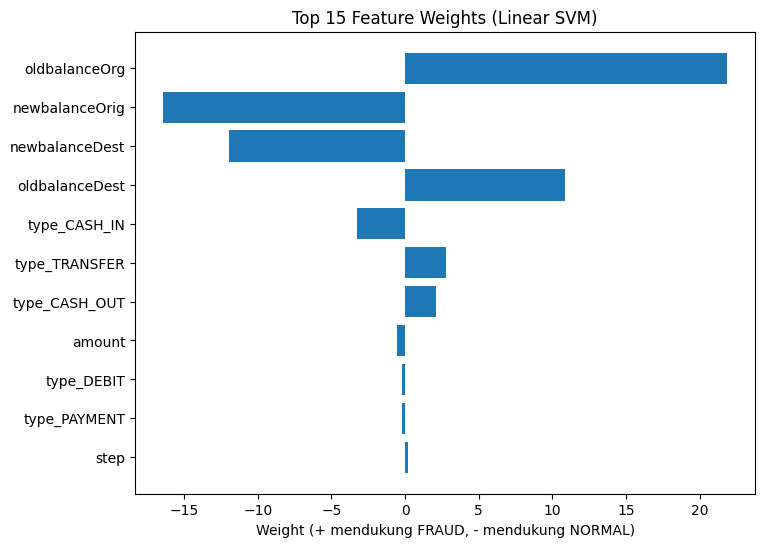

In [38]:
# CATATAN: Cell ini HARUS dijalankan SETELAH cell 11 (setelah best_linear didefinisikan)
import numpy as np
import pandas as pd

# ambil preprocessor & model dari pipeline
prep = best_linear.named_steps["prep"]
clf  = best_linear.named_steps["clf"]

# nama fitur hasil transform (numerik + onehot)
num_features = num_cols
cat_features = list(prep.named_transformers_["cat"].get_feature_names_out(["type"]))
feature_names = num_features + cat_features

# bobot model
weights = clf.coef_.ravel()

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "weight": weights,
    "abs_weight": np.abs(weights)
}).sort_values("abs_weight", ascending=False)

display(feat_imp.head(15))

plt.figure(figsize=(8,6))
top = feat_imp.head(15).sort_values("abs_weight")
plt.barh(top["feature"], top["weight"])
plt.title("Top 15 Feature Weights (Linear SVM)")
plt.xlabel("Weight (+ mendukung FRAUD, - mendukung NORMAL)")
plt.show()


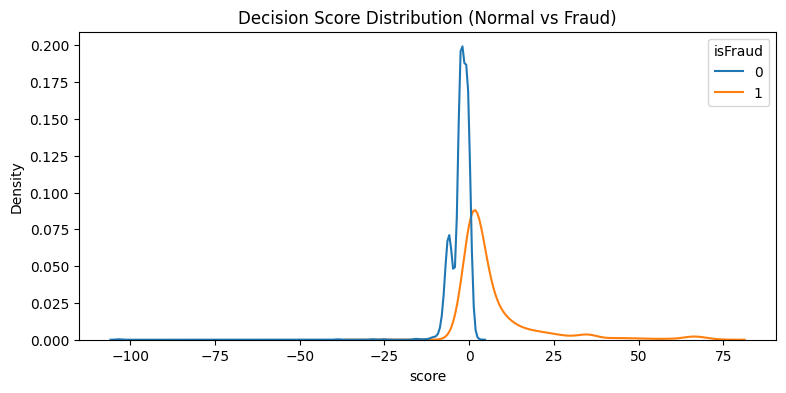

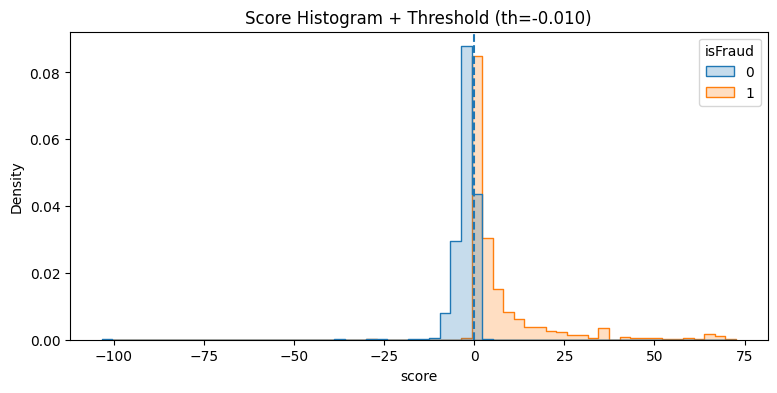

In [39]:
# CATATAN: Cell ini HARUS dijalankan SETELAH cell 11 (setelah best_linear didefinisikan)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

scores = best_linear.decision_function(X_test)

plot_df = pd.DataFrame({"score": scores, "isFraud": y_test.values})

plt.figure(figsize=(9,4))
sns.kdeplot(data=plot_df, x="score", hue="isFraud", common_norm=False)
plt.title("Decision Score Distribution (Normal vs Fraud)")
plt.show()

# Contoh threshold (median score)
th = np.median(scores)
plt.figure(figsize=(9,4))
sns.histplot(data=plot_df, x="score", hue="isFraud", bins=60, element="step", stat="density")
plt.axvline(th, linestyle="--")
plt.title(f"Score Histogram + Threshold (th={th:.3f})")
plt.show()


In [40]:
# CATATAN: Cell ini HARUS dijalankan SETELAH cell 11 (setelah best_linear didefinisikan)
sample_input = pd.DataFrame([{
    "step": 1,
    "type": "TRANSFER",
    "amount": 5000,
    "oldbalanceOrg": 10000,
    "newbalanceOrig": 5000,
    "oldbalanceDest": 0,
    "newbalanceDest": 0
}])

pred = best_linear.predict(sample_input)[0]
print("Prediksi:", "FRAUD" if pred==1 else "NORMAL")


Prediksi: FRAUD


In [41]:
# CATATAN: Cell ini HARUS dijalankan SETELAH cell 11 (setelah best_linear didefinisikan)
import joblib

joblib.dump(best_linear, "svm_fraud_pipeline.pkl")
print("Saved -> svm_fraud_pipeline.pkl")


Saved -> svm_fraud_pipeline.pkl
